In [28]:
# Gym stuff
import gymnasium as gym
import gym_anytrading
import torch

# Stable baselines - rl stuff
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import seaborn as sns
import os

In [29]:
df = pd.read_csv('../data/gmedata.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,03/12/2021,275.00,295.50,262.27,264.5,"25,845,900"
1,03/11/2021,241.64,281.50,232.60,260.0,"28,312,490"
2,03/10/2021,269.43,348.50,172.00,265.0,"71,570,570"
3,03/09/2021,217.71,249.85,208.51,246.9,"39,099,328"
4,03/08/2021,154.89,210.87,146.10,194.5,"63,565,621"


In [30]:
# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-03-12,275.00,295.50,262.27,264.5,"25,845,900"
2021-03-11,241.64,281.50,232.60,260.0,"28,312,490"
2021-03-10,269.43,348.50,172.00,265.0,"71,570,570"
2021-03-09,217.71,249.85,208.51,246.9,"39,099,328"
2021-03-08,154.89,210.87,146.10,194.5,"63,565,621"


In [34]:
# Create the environment setup by gym_anytrading
env = gym.make('stocks-v0', df=df, frame_bound=(5,8000), window_size=5)
# It is to be noted that the first element of frame_bound should be greater than or equal to window_size.

In [35]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> Action space:", env.unwrapped.action_space)
print("> Observation space:", env.unwrapped.observation_space)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env information:
> shape: (5, 2)
> Action space: Discrete(2)
> Observation space: Box(-10000000000.0, 10000000000.0, (5, 2), float32)
> df.shape: (251, 5)
> prices.shape: (251,)
> signal_features.shape: (251, 2)
> max_possible_profit: 2904.8002432999133


In [36]:
# Print Stats
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()

In [ ]:
# Train + Test the environment

seed = 42  # random seed
total_num_episodes = 50

print ("seed :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Train vectorized environment
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5,8000), window_size=5)
env = DummyVecEnv([env_maker])

model = PPO('MlpPolicy', env, verbose=0) 
model.learn(total_timesteps=100000, callback=ProgressBarCallback(100))

# Define the directory to save the model
save_dir = "../models/"
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

# Find the next version number
version = 1
while os.path.exists(f"{save_dir}model_v{version}"):
    version += 1

# Save the model with the new version number
model.save(f"{save_dir}model_v{version}")

seed : 42


model.learn():   0%|          | 0/100000 [00:00<?, ?it/s]

model.learn(): 100300it [06:11, 269.84it/s]                            


info: {'total_reward': -14.350002527236938, 'total_profit': 0.15960203432492523, 'position': <Positions.Short: 0>}
Total reward: -14.350002527236938


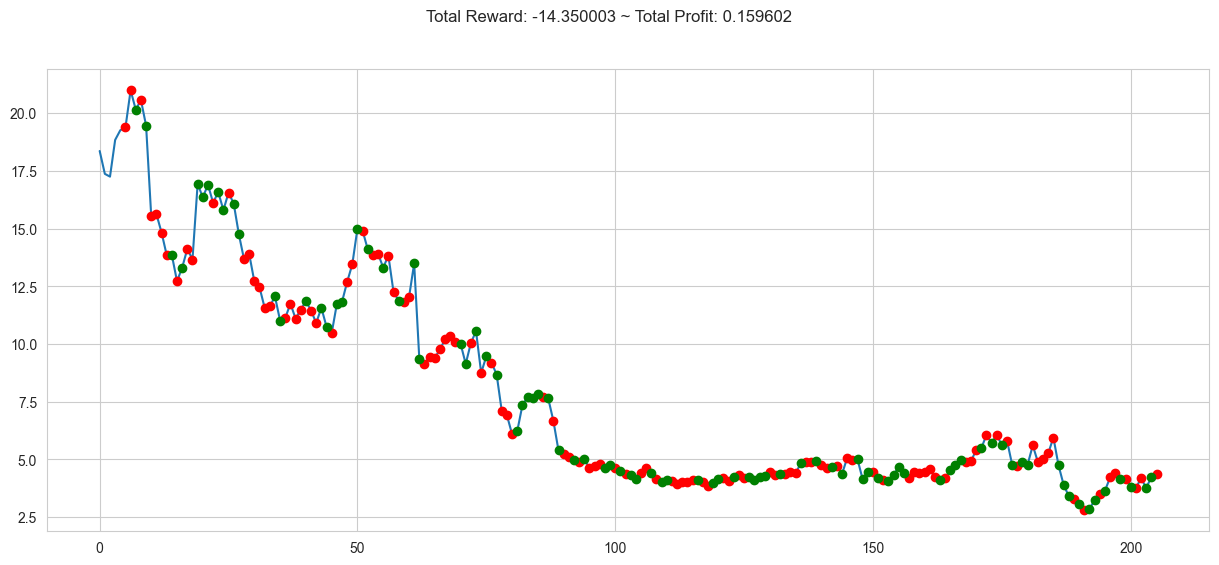

In [27]:
# Initialize the environment
env = gym.make('stocks-v0', df=df, frame_bound=(50, 300), window_size=5)
model = PPO.load("../models/model_v2")  # Change to your saved model path

# Test the model
observation, info = env.reset()  # Reset the environment

done = False
total_reward = 0

while not done:
    action, _states = model.predict(observation)  # Get action from the model
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward  # Accumulate the reward
    done = terminated or truncated  # Check if episode is done
    
    if done:
        print("info:", info)  # Output additional information when done
        break


print(f"Total reward: {total_reward}")
# Plot the results
plt.figure(figsize=(15, 6))
plt.cla()
# Ensure this method is correctly defined in your environment
env.unwrapped.render_all()  
plt.show()